In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from librosa.core import resample, to_mono
from pathlib import Path
import librosa
import librosa.display
from IPython.display import Audio, IFrame, display
import IPython.display as ipd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

## Check the metadata and the sound track metadata files to understand the training dataset.

In [2]:
# Load one of the two csv files.
train_metadata = pd.read_csv("../data/birdclef-2021/train_metadata.csv")

# Show what's captured in the train_metadata.csv file. 
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     62874 non-null  object 
 1   secondary_labels  62874 non-null  object 
 2   type              62874 non-null  object 
 3   latitude          62874 non-null  float64
 4   longitude         62874 non-null  float64
 5   scientific_name   62874 non-null  object 
 6   common_name       62874 non-null  object 
 7   author            62874 non-null  object 
 8   date              62874 non-null  object 
 9   filename          62874 non-null  object 
 10  license           62874 non-null  object 
 11  rating            62874 non-null  float64
 12  time              62874 non-null  object 
 13  url               62874 non-null  object 
dtypes: float64(3), object(11)
memory usage: 6.7+ MB


In [3]:
# Check the first 3 rows of the dataframe train_metadata.
train_metadata.head(3)

primary_label secondary_labels                                  type  \
0        acafly       ['amegfi']  ['begging call', 'call', 'juvenile']   
1        acafly               []                              ['call']   
2        acafly               []                              ['call']   

   latitude  longitude      scientific_name         common_name  \
0   35.3860   -84.1250  Empidonax virescens  Acadian Flycatcher   
1    9.1334   -79.6501  Empidonax virescens  Acadian Flycatcher   
2    5.7813   -75.7452  Empidonax virescens  Acadian Flycatcher   

                    author        date      filename  \
0              Mike Nelson  2012-08-12  XC109605.ogg   
1        Allen T. Chartier  2000-12-26   XC11209.ogg   
2  Sergio Chaparro-Herrera  2012-01-10  XC127032.ogg   

                                             license  rating   time  \
0  Creative Commons Attribution-NonCommercial-Sha...     2.5  09:30   
1  Creative Commons Attribution-NonCommercial-Sha...     3.0      ?   
2  Creative Commons Attribution-NonCommercial-Sha...     3.0  15:20   

                                 url  
0  https://www.xeno-canto.org/109605  
1   https://www.xeno-canto.org/11209  
2  https://www.xeno-canto.org/127032

In [4]:
# Check the shape of the dataframe train_metadata.
train_metadata.shape

(62874, 14)

In [5]:
# Load one of the other csv file.
train_soundscape = pd.read_csv("../data/birdclef-2021/train_soundscape_labels.csv")

# Show what's captured in the train_soundscape_labels.csv file. 

train_soundscape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    2400 non-null   object
 1   site      2400 non-null   object
 2   audio_id  2400 non-null   int64 
 3   seconds   2400 non-null   int64 
 4   birds     2400 non-null   object
dtypes: int64(2), object(3)
memory usage: 93.9+ KB


In [6]:
# Check the first 3 rows of the dataframe train_soundscape.
train_soundscape.head(3)

row_id site  audio_id  seconds   birds
0   7019_COR_5  COR      7019        5  nocall
1  7019_COR_10  COR      7019       10  nocall
2  7019_COR_15  COR      7019       15  nocall

In [7]:
# Check the shape of the dataframe train_soundscape.
train_soundscape.shape

(2400, 5)

## Found out the size of the dataset is decent. Need more visualization to quickly see the data distribution etc.

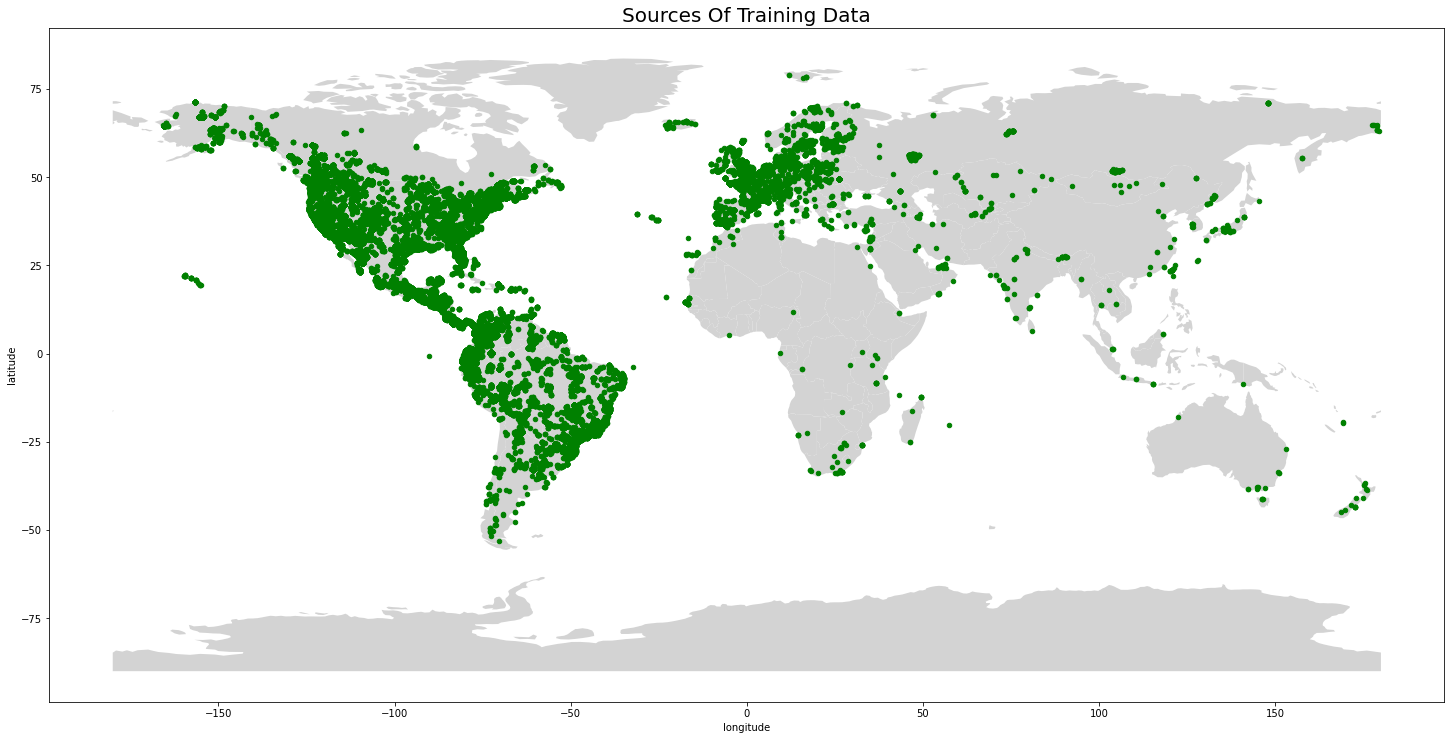

In [8]:
# Show the sources of the training data in the world map.
# The birds outside of North Americas, South Americas and Europe are under-represented in this training dataset.
# This implies that our mobile app won't work as well in Australia as in the US.
fig, ax = plt.subplots(figsize=(25, 20))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color="lightgrey", ax=ax)

train_metadata.plot(x="longitude", y="latitude", kind="scatter", c="green", colormap="YlOrRd", 
        title="Sources Of Training Data", ax=ax)
ax.title.set_size(20)

plt.show()

In [9]:
# Check how many classes of birds are in the training dataset.
# Notice that there are 397 classes of birds.
print("The number of classes of bird in the training dataset: " + str(len(train_metadata['primary_label'].unique()))) 


The number of classes of bird in the training dataset: 397


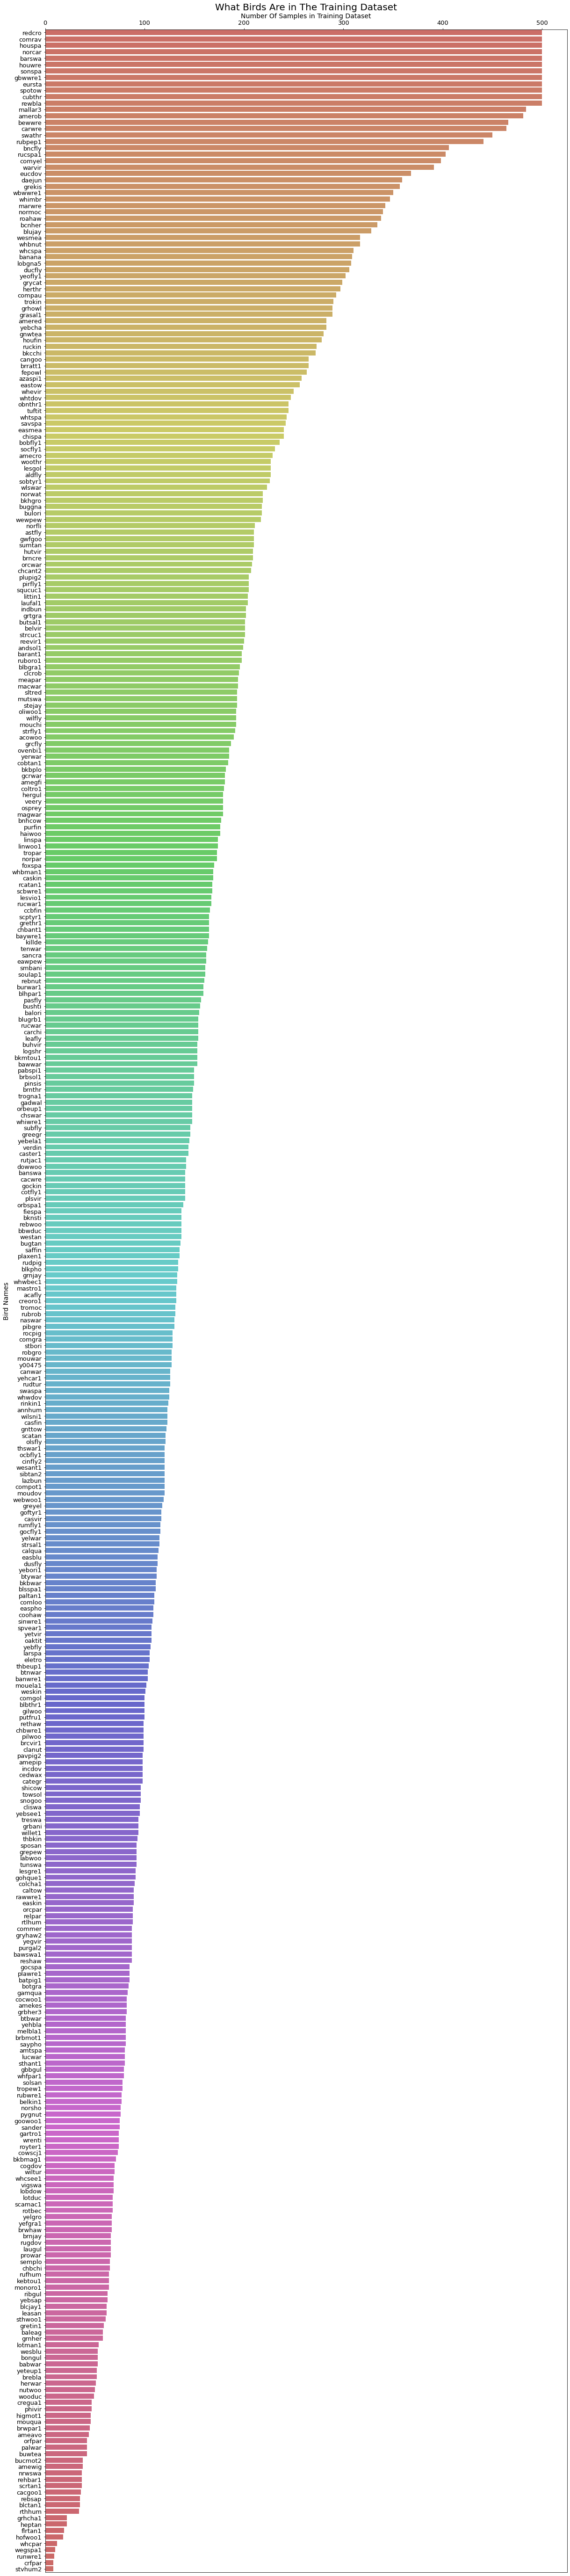

In [10]:
# Create a plot to show the number of samples per class of bird in the training dataset.
# Notice that the training dataset is very imbalanced.
plt.figure(figsize=(20, 100))
ax = sns.countplot(y = train_metadata['primary_label'], palette="hls", 
                   order = train_metadata['primary_label'].value_counts().index)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.title("What Birds Are in The Training Dataset", fontsize = 20)
plt.ylabel("Bird Names", fontsize = 14)
plt.xlabel("Number Of Samples in Training Dataset", fontsize = 14)
plt.show()

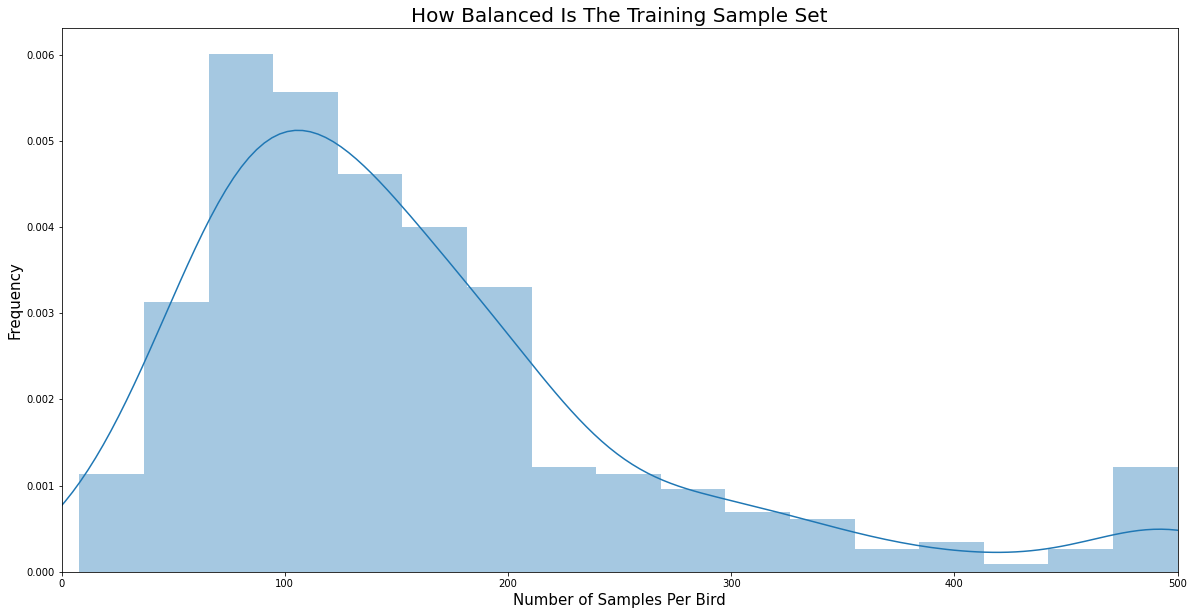

In [11]:
# Samples in the training set are distributed across the birds in a distribution depicted here. The model is likely
# to be affected by this distribution where some birds have a lot more training samples and all other things equal
# can improve classification, while birds with small training sets may have lower accuracy in classification.

plt.figure(figsize=(20, 10))
sample_count = train_metadata['primary_label'].value_counts()
ax = sns.distplot(sample_count)
plt.xlim(0, 500)
plt.title("How Balanced Is The Training Sample Set", fontsize = 20)
plt.xlabel("Number of Samples Per Bird", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.show()

In [12]:
# Check how many classes have fewer than 75 samples and obtain a quick view of the classes with the smallest numbers.
# Notice there are 69 classes of bird that have fewer than 75 samples. Some even have as few as 8 samples.
# Suggest remove these samples of these types from the training dataset to improve training performance.

train_metadata['primary_label'].value_counts().sort_values(ascending=True).loc[lambda x : x < 75] 

stvhum2     8
crfpar      8
runwre1     9
wegspa1    10
whcpar     12
           ..
bkbmag1    71
cowscj1    73
royter1    74
wrenti     74
gartro1    74
Name: primary_label, Length: 69, dtype: int64

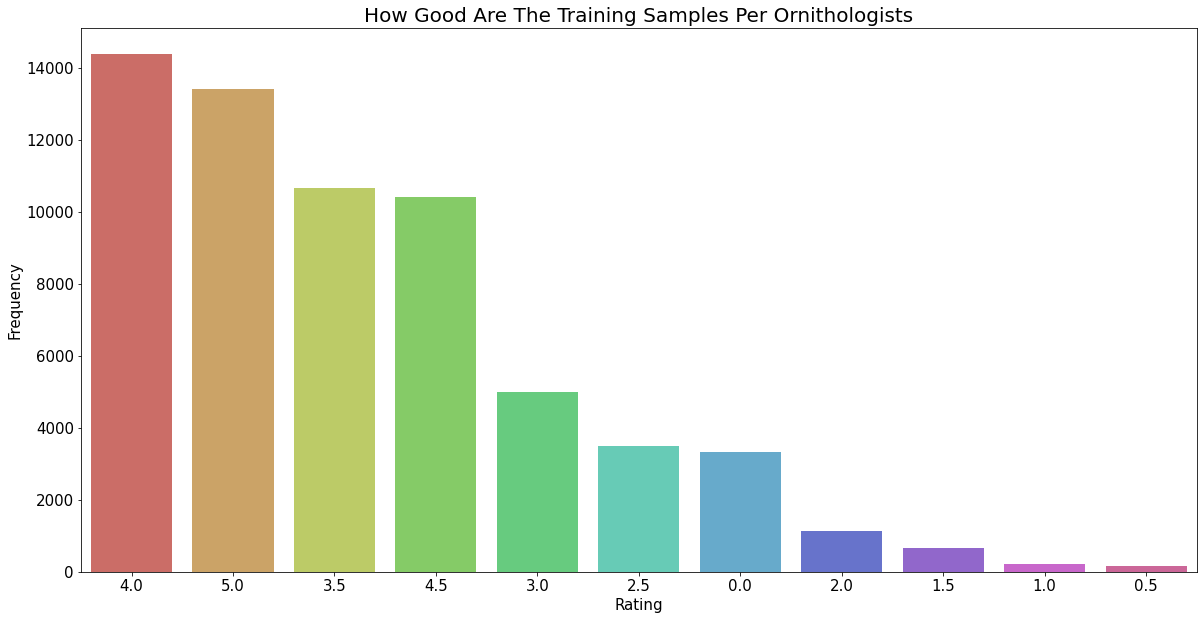

In [13]:
# Ornithologists provided their expert rating on the quality of the training samples. Let's see how they think of 
# the quality of training data.
plt.figure(figsize=(20, 10))
ax = sns.countplot(x = train_metadata['rating'], palette="hls", order = train_metadata['rating'].value_counts().index)

plt.title("How Good Are The Training Samples Per Ornithologists", fontsize = 20)
plt.ylabel("Frequency", fontsize = 15)
plt.xlabel("Rating", fontsize = 15)
plt.yticks(fontsize = 15) 
plt.xticks(rotation = 0, fontsize = 15) 
plt.show()

In [14]:
# Explore further into the column "type" in train_metadata.
# Clean up the format so that we can make a plot to show the distribution of different types of bird sounds.

type2 = train_metadata['type'].apply(lambda x: x.replace('[', ''))
type2 = type2.apply(lambda x: x.replace(']', ''))

type2 = type2.apply(lambda x: x.split(',')).reset_index().explode("type")

type2 = type2['type'].apply(lambda x: x.strip().lower()).reset_index()
type2['type'] = type2['type'].replace('calls', 'call')

Text(0.5, 0, 'Type')

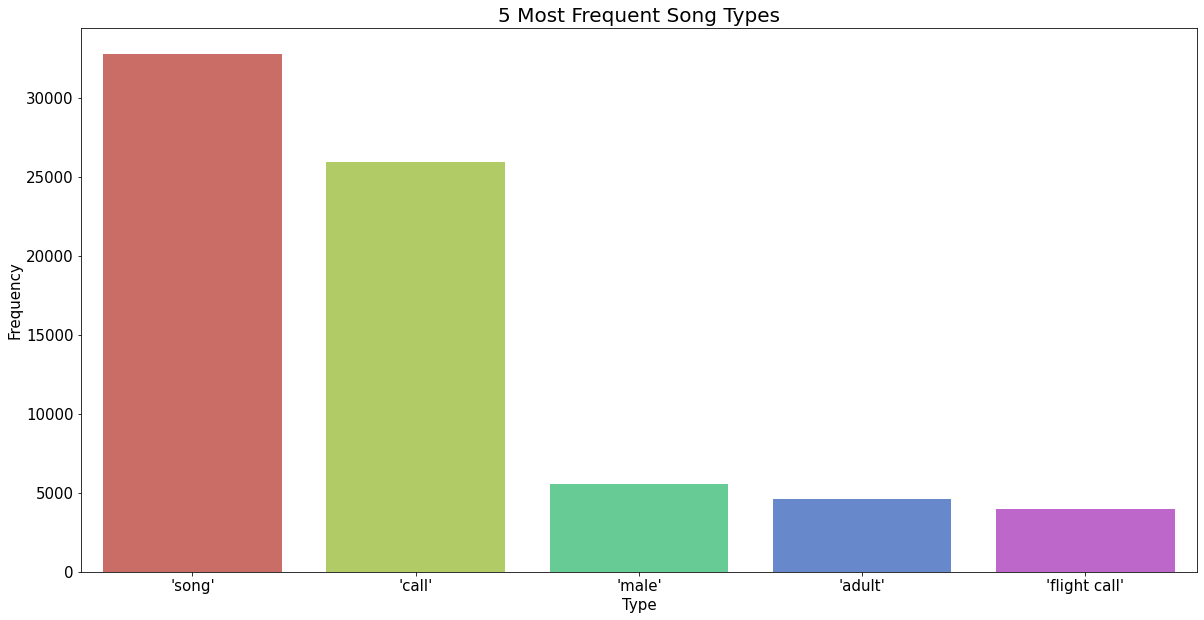

In [15]:
# Create a plot to show the 5 most frequent types of bird sound.
most_frequent = list(type2['type'].value_counts().head(5).reset_index()['index'])
data = type2[type2['type'].isin(most_frequent)]

plt.figure(figsize=(20, 10))
ax = sns.countplot(data['type'], palette="hls", order = data['type'].value_counts().index)

plt.title("5 Most Frequent Song Types", fontsize = 20)
plt.ylabel("Frequency", fontsize = 15)
plt.yticks(fontsize = 15) 
plt.xticks(rotation = 0, fontsize = 15) 
plt.xlabel("Type", fontsize = 15)

## Ok, enough about metadata. I want to listen to the birds singing songs.

In [16]:
# Create a full path for the audio files so that it's easier to play a sound track
audio ='../data/birdclef-2021/train_short_audio'
train_metadata['full_path'] = audio + '/' + train_metadata['primary_label'] + '/' + train_metadata['filename']

In [17]:
# Some people believe the thrushes, such as the Wood Thrush, or the Veery, have the most beautiful bird songs.
woothr = train_metadata[train_metadata['primary_label'] == "woothr"].sample(1, random_state = 33)['full_path'].values[0]

ipd.Audio(woothr)

In [18]:
# Here are veery birds
veery = train_metadata[train_metadata['primary_label'] == "veery"].sample(1, random_state = 33)['full_path'].values[0]

ipd.Audio(veery)

In [19]:
# One of the most common class of birds in this training dataset.
redcro = train_metadata[train_metadata['primary_label'] == "redcro"].sample(1, random_state = 33)['full_path'].values[0]

ipd.Audio(redcro)

## I really like listening to the bird songs. Can we "see" the bird songs?


In [20]:
# librosa loads an audio file as a floating point time series for its signal (y) and gives it's native 
# sampling rate (sr) which is the number of data points per second in an audio.
y_woothr, sr_woothr = librosa.load(woothr)
audio_woothr, _ = librosa.effects.trim(y_woothr)

y_veery, sr_veery = librosa.load(veery)
audio_veery, _ = librosa.effects.trim(y_veery)

y_redcro, sr_redcro = librosa.load(redcro)
audio_redcro, _ = librosa.effects.trim(y_redcro)

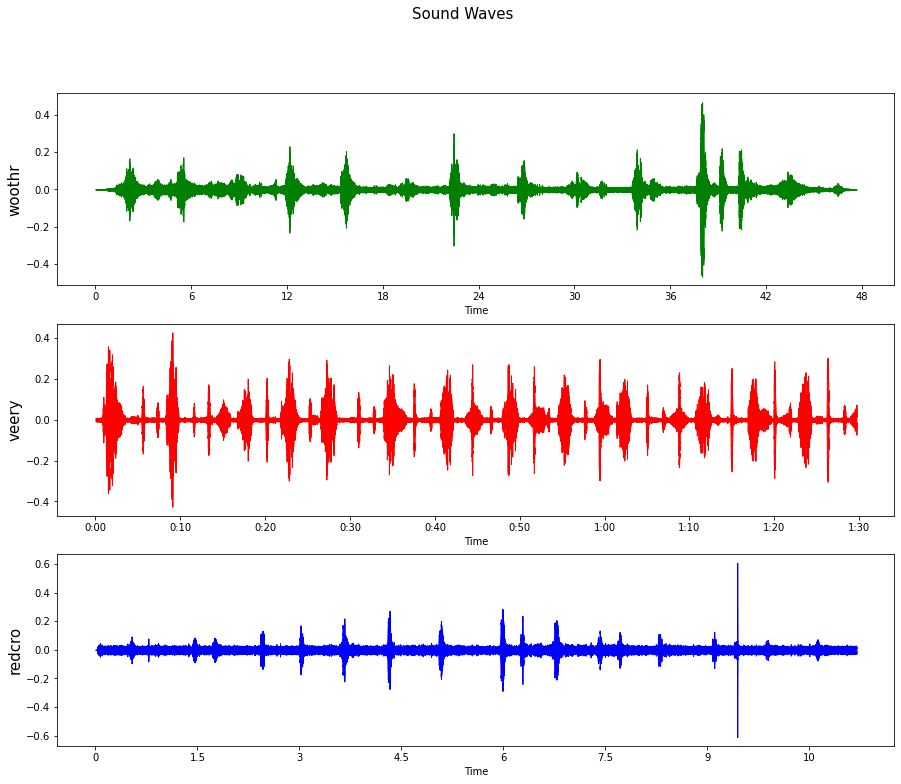

In [21]:
# Check the waveform visualization of the amplitude vs the time representation of the 3 sound tracks.
fig, ax = plt.subplots(3, figsize = (15, 12))
fig.suptitle('Sound Waves', fontsize = 15)
bird_list = ["woothr", "veery", "redcro"]

librosa.display.waveshow(y = audio_woothr, sr = sr_woothr, color = "g", ax = ax[0])
librosa.display.waveshow(y = audio_veery, sr = sr_veery, color = "r", ax = ax[1])
librosa.display.waveshow(y = audio_redcro, sr = sr_redcro, color = "b", ax = ax[2]);

for i, name in zip(range(3), bird_list):
    ax[i].set_ylabel(name, fontsize = 15)

## Spectrogram - How our machine learning models are going to "see" the bird sounds?
#### A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. A spetrogram represents the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. 

In [22]:
n_fft = 2048
hop_length = 512

# Short-time Fourier transform (STFT) converts an audio file and obtain the amplitude of the given frequency at a 
## given time. 
d_woothr = np.abs(librosa.stft(audio_woothr, n_fft = n_fft, hop_length = hop_length))
d_veery = np.abs(librosa.stft(audio_veery, n_fft = n_fft, hop_length = hop_length))
d_redcro = np.abs(librosa.stft(audio_redcro, n_fft = n_fft, hop_length = hop_length))

# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
db_woothr = librosa.amplitude_to_db(d_woothr, ref = np.max)
db_veery = librosa.amplitude_to_db(d_veery, ref = np.max)
db_redcro = librosa.amplitude_to_db(d_redcro, ref = np.max)

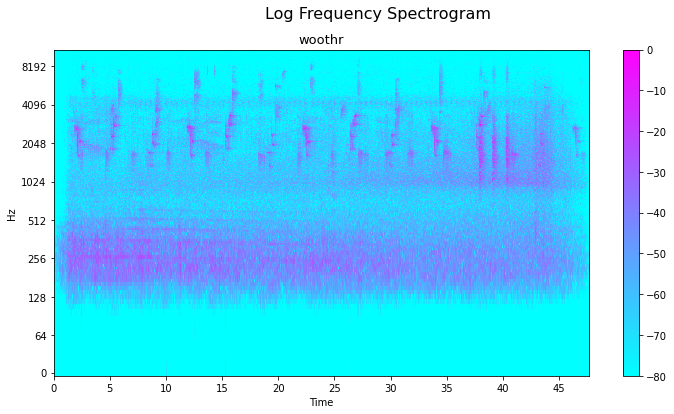

In [23]:
# Create a heatmap to display a log-frequency spectrogram. Features can be obtained from a spectrogram by converting the 
## linear frequency axis into a logarithmic axis.
fig, ax = plt.subplots(1, 1, figsize= (12, 6))
fig.suptitle('Log Frequency Spectrogram', fontsize = 16)
spec_woothr = librosa.display.specshow(db_woothr, sr = sr_woothr, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax = ax)
ax.set_title('woothr', fontsize=13) 
plt.colorbar(spec_woothr, ax = ax)


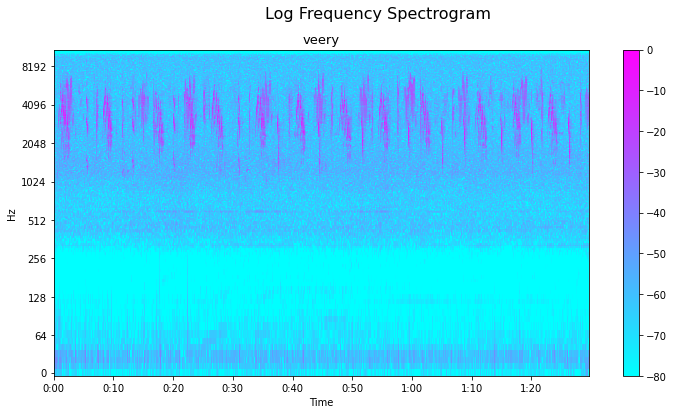

In [24]:
fig, ax = plt.subplots(1, 1, figsize= (12, 6))
fig.suptitle('Log Frequency Spectrogram', fontsize = 16)
spec_veery = librosa.display.specshow(db_veery, sr = sr_veery, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax = ax)
ax.set_title('veery', fontsize=13) 
plt.colorbar(spec_veery, ax = ax)

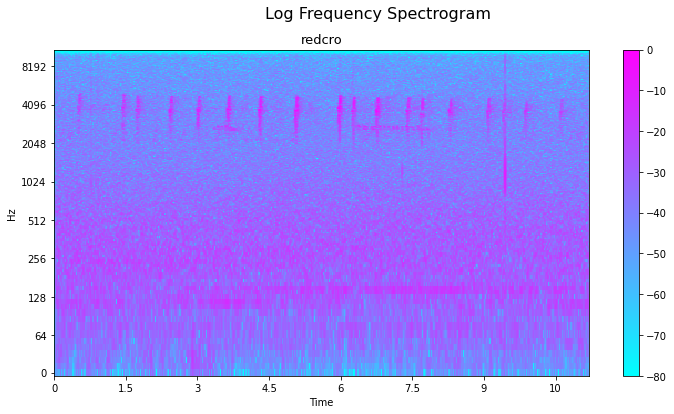

In [25]:
fig, ax = plt.subplots(1, 1, figsize= (12, 6))
fig.suptitle('Log Frequency Spectrogram', fontsize = 16)
spec_redcro = librosa.display.specshow(db_redcro, sr = sr_redcro, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax = ax)
ax.set_title('redcro', fontsize=13) 
plt.colorbar(spec_redcro, ax = ax)

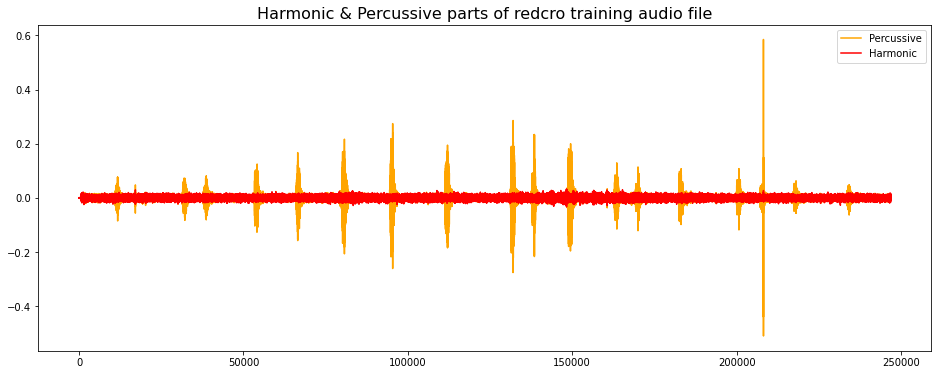

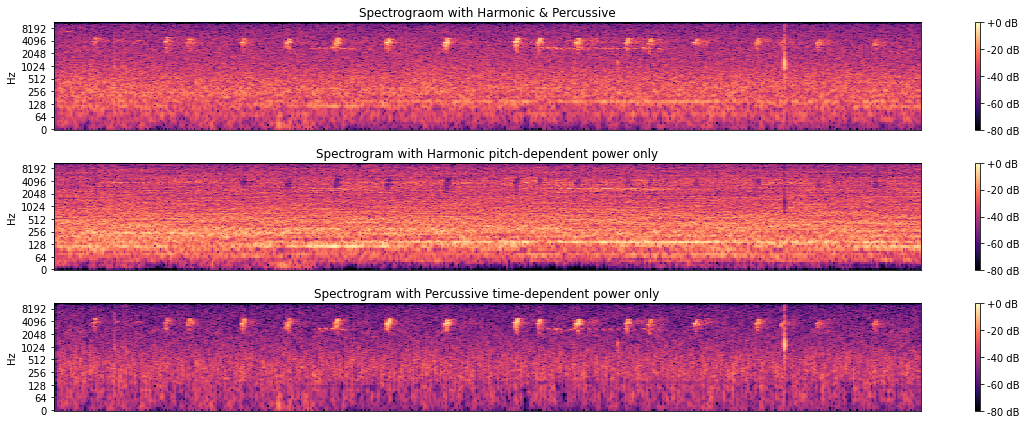

In [26]:
# Separating the sounds in the spectrograms can help reduce noises from nearby machines, human activity, etc and
# train on only the sound made by the bird. For example, someone hitting a hammer on a nail or any human equipment
# performing similar functions will have a percussive sound. A machine or musical instrument with repetitive 
# actions in the background may make more harmonic sounds.

def plot_harmonic_percussion_noises(audio, birdname, db):
    y_harm, y_perc = librosa.effects.hpss(audio)
    plt.figure(figsize = (16, 6))
    plt.plot(y_perc, color = 'orange')
    plt.plot(y_harm, color = 'red')
    plt.legend(("Percussive", "Harmonic"))
    plt.title(f"Harmonic & Percussive parts of {birdname} training audio file", fontsize=16);

    H, P = librosa.decompose.hpss(librosa.stft(audio))    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(3, 1, 1)
    librosa.display.specshow(db, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrograom with Harmonic & Percussive')

    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(H), ref=np.max), y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram with Harmonic pitch-dependent power only')
    
    plt.subplot(3, 1, 3)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(P), ref=np.max), y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram with Percussive time-dependent power only')
    
    plt.tight_layout()
    plt.show()

plot_harmonic_percussion_noises(audio_redcro, "redcro", db_redcro)

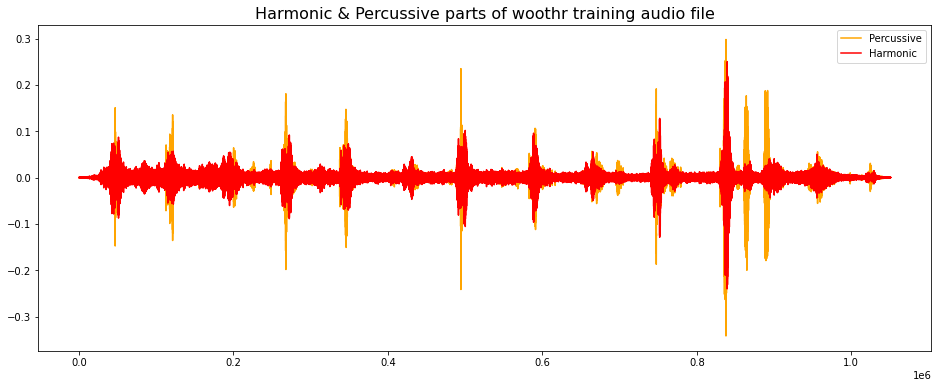

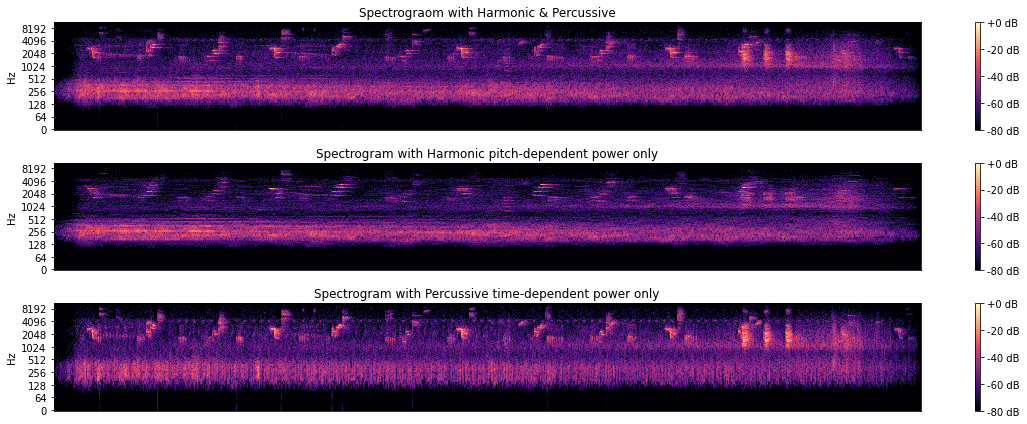

In [27]:
# It appears that the bird's sound is in the percussive part, while the harmonic part is mostly background noises.
# However, have harmonic parts of their calls/songs which can merge with the harmonic noises in the background
# resulting in difficulty separating the noises.

plot_harmonic_percussion_noises(audio_woothr, "woothr", db_woothr)

The training dataset contains audio files with a variety of background noises. While model training using a diversity of sample audio files can reduce the weights assigned in the neural network to distinct noises from specific training files, audio files for the same species of bird from roughly the same region can introduce common noises across the training set, affecting the accuracy and precision of classification. In these instances, it is valuable to filter out the noise, but then adds a similar filtering requirement for the classification task on the final model. 

However, another approach is to add our own white noise to all audio files to improve accuracy of the classification in the test set and in the final model. This white noise in addition to other regularization techniques will be important to improve accuracy of our classification.